In [9]:
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from joblib import dump, load
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import resample

In [10]:
# File paths
#stutter_labels_file = 'SEP-28k_stutter_labels.csv'
#mfcc_features_file = 'mfcc_features_new.csv'
stutter_labels_file = 'data/SEP-28k_labels_updated.csv'
mfcc_features_file = 'data/mfcc_features_new_1.csv'

# Load datasets
stutter_labels_df = pd.read_csv(stutter_labels_file)
mfcc_features_df = pd.read_csv(mfcc_features_file)

In [11]:
# # Focusing on specific labels
# labels = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection', 'NoStutteredWords']

# # Selecting only the specified labels from the dataset
# data_subset = stutter_labels_df[labels]

# # Applying the rules to convert labels to binary
# # Rule: If one of these labels has a value greater than the others in the row, turn it into 1 and others into 0
# binary_labels = data_subset.apply(lambda row: (row == row.max()) & (row > 0), axis=1).astype(int)

# # Previewing the transformed data
# binary_labels.head(20)

In [12]:
# Ensure row count matches
assert stutter_labels_df.shape[0] == mfcc_features_df.shape[0], "Row counts do not match"

In [13]:
# Label Encoding
label_encoder = LabelEncoder()
stutter_labels_df['label'] = label_encoder.fit_transform(
    stutter_labels_df[['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection', 'NoStutteredWords']].idxmax(axis=1))

In [14]:
stutter_labels_df.head()
# Specify the file path where you want to save the CSV file
file_path = "lables.csv"  # Replace with your desired file name and path

# Save the DataFrame to a CSV file
stutter_labels_df.to_csv(file_path, index=False)

In [15]:
stutter_labels_df.count()

unique_id                27922
Show                     27922
EpId                     27922
ClipId                   27922
Start                    27922
Stop                     27922
Unsure                   27922
PoorAudioQuality         27922
Prolongation             27922
Block                    27922
SoundRep                 27922
WordRep                  27922
DifficultToUnderstand    27922
Interjection             27922
NoStutteredWords         27922
NaturalPause             27922
Music                    27922
NoSpeech                 27922
audio_name_from_clips    27922
AudioFilePath            27922
label                    27922
dtype: int64

In [16]:
# Combine features with labels
combined_df = pd.concat([mfcc_features_df, stutter_labels_df['label']], axis=1)

In [17]:
combined_df.head()
combined_df.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '119', '120', '121', '122', '123', '124', '125', '126', '127', 'label'],
      dtype='object', length=129)

In [18]:
# Handle NaN values
imputer = SimpleImputer(strategy='mean')
combined_df = pd.DataFrame(imputer.fit_transform(combined_df), columns=combined_df.columns)

In [19]:
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,label
0,-383.23590,49.986275,2.692035,14.354122,1.777423,-2.420321,-12.342792,1.071969,-9.256073,-6.607179,...,-0.037875,-0.441928,-0.021258,0.102335,0.224355,0.111586,-0.074551,-0.277180,0.029687,2.0
1,-360.24127,66.061165,-1.453862,11.259468,-4.462043,-0.253932,-5.415998,-6.300482,-7.769228,-6.499992,...,0.067139,0.023550,0.417576,0.357839,0.149729,-0.069849,-0.042405,0.169478,-0.104200,2.0
2,-293.65506,73.833070,1.900996,-2.408337,-4.000989,1.076603,-3.904765,-3.917793,-7.314900,-5.230086,...,0.014711,-0.298602,0.326214,0.391751,0.288665,-0.067893,-0.128538,0.098275,0.382504,2.0
3,-300.60464,52.587803,-1.105800,22.788185,-2.626716,-5.491357,-18.113768,0.016458,-17.751234,-10.870638,...,0.289682,-0.008517,0.129649,0.145712,-0.106505,0.626362,0.452814,0.210945,0.049662,2.0
4,-322.67563,39.411556,-26.036314,31.284819,-20.774286,-5.054771,-8.849819,-4.670222,-6.783212,-8.442829,...,0.037181,-0.015063,-0.082885,-0.019881,0.002105,-0.235956,-0.074217,0.219122,-0.041756,2.0


In [20]:
# Separate majority and minority classes for resampling
df_majority = combined_df[combined_df.label == 2]
df_minorities = [combined_df[combined_df.label == label] for label in range(6) if label != 2]

# Upsample minority classes
df_minority_upsampled = [resample(df,
                                  replace=True,     
                                  n_samples=df_majority.shape[0],    
                                  random_state=123) for df in df_minorities]

# Combine majority class with upsampled minority classes
df_upsampled = pd.concat([df_majority] + df_minority_upsampled)


In [21]:
# Split data
X = df_upsampled.drop('label', axis=1).values  # Convert to NumPy array
y = to_categorical(df_upsampled['label'].values)  # One-hot encoding

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM [samples, time steps, features]
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

In [22]:
# LSTM Model for multi-class classification
number_of_classes = y.shape[1]
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(number_of_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [214]:
# Train model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_data=(X_test_scaled, y_test))

Epoch 1/10
1947/1947 [==============================] - 28s 12ms/step - loss: 1.6862 - accuracy: 0.2918 - val_loss: 1.5746 - val_accuracy: 0.3708
Epoch 2/10
1947/1947 [==============================] - 22s 11ms/step - loss: 1.5453 - accuracy: 0.3820 - val_loss: 1.4631 - val_accuracy: 0.4313
Epoch 3/10
1947/1947 [==============================] - 21s 11ms/step - loss: 1.4558 - accuracy: 0.4276 - val_loss: 1.3803 - val_accuracy: 0.4698
Epoch 4/10
1947/1947 [==============================] - 22s 11ms/step - loss: 1.3904 - accuracy: 0.4574 - val_loss: 1.3180 - val_accuracy: 0.4970
Epoch 5/10
1947/1947 [==============================] - 21s 11ms/step - loss: 1.3356 - accuracy: 0.4828 - val_loss: 1.2670 - val_accuracy: 0.5236
Epoch 6/10
1947/1947 [==============================] - 21s 11ms/step - loss: 1.2987 - accuracy: 0.4969 - val_loss: 1.2267 - val_accuracy: 0.5390
Epoch 7/10
1947/1947 [==============================] - 21s 11ms/step - loss: 1.2640 - accuracy: 0.5148 - val_loss: 1.1882 -

487/487 [==============================] - 3s 4ms/step
Accuracy: 0.163135593220339
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.19      0.18      2563
           1       0.15      0.19      0.17      2654
           2       0.14      0.18      0.16      2568
           3       0.20      0.23      0.21      2605
           4       0.13      0.06      0.09      2681
           5       0.18      0.12      0.14      2505

    accuracy                           0.16     15576
   macro avg       0.16      0.16      0.16     15576
weighted avg       0.16      0.16      0.16     15576



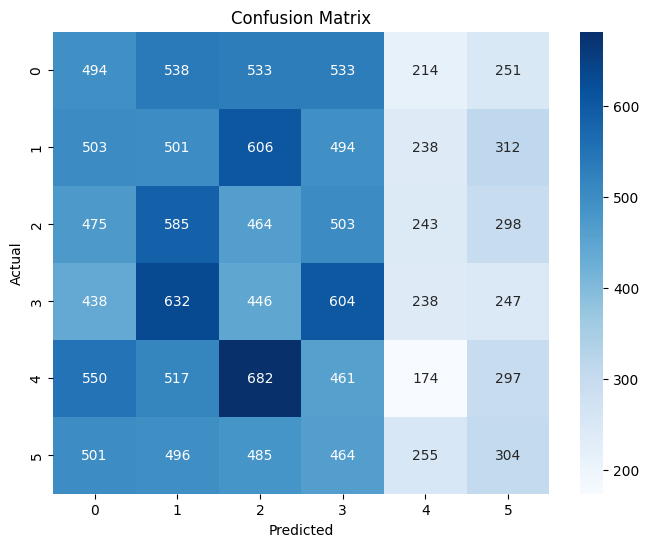

In [23]:
# Evaluate model
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
report = classification_report(y_test_classes, y_pred_classes)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

# Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [216]:
# Save model and scaler
model_save_path = 'models/lstm_model_multiclass.h5'
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

scaler_save_path = 'models/scaler_for_multiclass.joblib'
dump(scaler, scaler_save_path)
print(f"Scaler saved to {scaler_save_path}")

Model saved to models/lstm_model_multiclass.h5
Scaler saved to models/scaler_for_multiclass.joblib


In [24]:
# Feature Extraction Function
def extract_mfcc_features(audio_file, n_mfcc=1000):
    y, sr = librosa.load(audio_file, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_scaled = np.mean(mfcc.T, axis=0)

    # Reshape for LSTM
    mfcc_scaled = mfcc_scaled.reshape(1, 1, -1)

    return mfcc_scaled

In [25]:
# Prediction Function
def predict_stutter_type(audio_file, model_path, scaler_path):
    # Load the scaler
    scaler = load(scaler_path)

    # Extract features
    mfcc_features = extract_mfcc_features(audio_file)
    mfcc_features_scaled = scaler.transform(mfcc_features[0])
    mfcc_features_scaled = mfcc_features_scaled.reshape(1, 1, -1)

    # Load the model
    model = tf.keras.models.load_model(model_path)

    # Make a prediction
    prediction = model.predict(mfcc_features_scaled)
    predicted_class = np.argmax(prediction, axis=1)

    # Map predicted class to label
    return label_encoder.inverse_transform(predicted_class)[0]

In [26]:
# Example usage
audio_file_path = 'HeStutters_1_14.wav'
model_path = 'models/lstm_model_multiclass.h5'
scaler_path = 'models/scaler_for_multiclass.joblib'

# Make a prediction
predicted_stutter_type = predict_stutter_type(audio_file_path, model_path, scaler_path)
print(f"Predicted Stutter Type: {predicted_stutter_type}")


1/1 [==============================] - 1s 800ms/step
Predicted Stutter Type: Prolongation


In [27]:
import os
import pandas as pd

audio_files_directory = 'D:\\Projects\\Python\\New_folder\\test\\'
model_path = 'models/lstm_model_multiclass.h5'
scaler_path = 'models/scaler_for_multiclass.joblib'

audio_files = [file for file in os.listdir(audio_files_directory) if file.endswith('.wav')]

# Initialize an empty list to store results
results = []

# Process each audio file
for audio_file in audio_files:
    audio_file_path = os.path.join(audio_files_directory, audio_file)
    
    # Make a prediction
    predicted_stutter_type = predict_stutter_type(audio_file_path, model_path, scaler_path)
    
    # Add the result to the list as a dictionary
    results.append({'AudioFile': audio_file, 'PredictedStutterType': predicted_stutter_type})

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV file
results_df.to_csv('stutter_prediction_results.csv', index=False)
print("All predictions are saved to stutter_prediction_results.csv")


1/1 [==============================] - 1s 734ms/step
All predictions are saved to stutter_prediction_results.csv


In [6]:
!pip install tkinter


ERROR: Could not find a version that satisfies the requirement tkinter (from versions: none)
ERROR: No matching distribution found for tkinter
You should consider upgrading via the 'D:\Projects\Python\New_folder\audio_env\Scripts\python.exe -m pip install --upgrade pip' command.


Epoch 1/10
1947/1947 [==============================] - 26s 12ms/step - loss: 1.6844 - accuracy: 0.2907 - val_loss: 1.5704 - val_accuracy: 0.3699
Epoch 2/10
1947/1947 [==============================] - 21s 11ms/step - loss: 1.5494 - accuracy: 0.3775 - val_loss: 1.4640 - val_accuracy: 0.4291
Epoch 3/10
1947/1947 [==============================] - 21s 11ms/step - loss: 1.4625 - accuracy: 0.4211 - val_loss: 1.3826 - val_accuracy: 0.4733
Epoch 4/10
1947/1947 [==============================] - 22s 11ms/step - loss: 1.3949 - accuracy: 0.4545 - val_loss: 1.3161 - val_accuracy: 0.5009
Epoch 5/10
1947/1947 [==============================] - 22s 11ms/step - loss: 1.3418 - accuracy: 0.4781 - val_loss: 1.2686 - val_accuracy: 0.5218
Epoch 6/10
1947/1947 [==============================] - 21s 11ms/step - loss: 1.3019 - accuracy: 0.4955 - val_loss: 1.2269 - val_accuracy: 0.5412
Epoch 7/10
1947/1947 [==============================] - 22s 11ms/step - loss: 1.2703 - accuracy: 0.5090 - val_loss: 1.1893 -

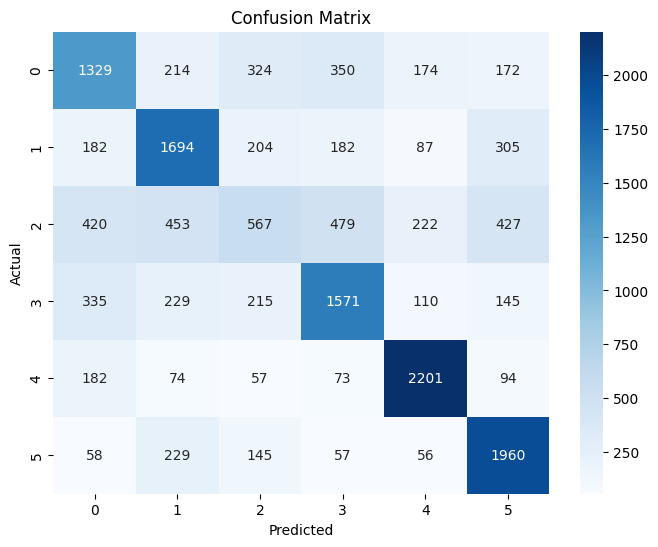

In [3]:

## Import classes
from Data_Handler import DataHandler
from Model_Manager import ModelManager

# Usage
data_handler = DataHandler('data/SEP-28k_labels_updated.csv', 'data/mfcc_features_new_1.csv')
data_handler.load_data()
data_handler.preprocess_data()

X_train_scaled, X_test_scaled, y_train, y_test = data_handler.get_data()

input_shape = (1, 128)  # Modify this based on your actual input data shape
model_manager = ModelManager(input_shape=input_shape, number_of_classes=y_train.shape[1])
#model_manager = ModelManager(input_shape=(1, X_train_scaled.shape[1]), number_of_classes=y_train.shape[1])
model_manager.train_model(X_train_scaled, y_train, X_test_scaled, y_test)
model_manager.evaluate_model(X_test_scaled, y_test)
model_manager.save_model('models/lstm_model_multiclass.h5')

data_handler.save_scaler('models/scaler_for_multiclass.joblib')
